# 0.Import library

In [ ]:
!pip install catboost
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time

from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE, RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from scipy.stats import uniform as sp_uniform

from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint

# 1.Read and preprocessing data

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [7]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project/test.csv')

In [ ]:
df_train.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,381109,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


In [ ]:
df_test.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265
127036,508146,Male,41,1,29.0,1,1-2 Year,No,27927.0,124.0,231


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
# Looking more detail at 3 'Object' type features like 'Gender', 'Vehicle_Age' and 'Vehicle_Damage'
def check_index_train():
    x = print(df_train.Gender.value_counts())
    y = print(df_train.Vehicle_Age.value_counts())
    z = print(df_train.Vehicle_Damage.value_counts())
    return x, y, z
check_index_train()

Male      206089
Female    175020
Name: Gender, dtype: int64
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64


(None, None, None)

# 2.Data Visualization

In [ ]:
# The max of Annual Premium is 540,165$ while the min is 24,405$.
df_train.describe().T.style.bar(
    subset=['mean'],
    color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
id,381109.000000,190555.000000,110016.836208,1.000000,95278.000000,190555.000000,285832.000000,381109.000000
Age,381109.000000,38.822584,15.511611,20.000000,25.000000,36.000000,49.000000,85.000000
Driving_License,381109.000000,0.997869,0.046110,0.000000,1.000000,1.000000,1.000000,1.000000
Region_Code,381109.000000,26.388807,13.229888,0.000000,15.000000,28.000000,35.000000,52.000000
Previously_Insured,381109.000000,0.458210,0.498251,0.000000,0.000000,0.000000,1.000000,1.000000
Annual_Premium,381109.000000,30564.389581,17213.155057,2630.000000,24405.000000,31669.000000,39400.000000,540165.000000
Policy_Sales_Channel,381109.000000,112.034295,54.203995,1.000000,29.000000,133.000000,152.000000,163.000000
Vintage,381109.000000,154.347397,83.671304,10.000000,82.000000,154.000000,227.000000,299.000000
Response,381109.000000,0.122563,0.327936,0.000000,0.000000,0.000000,0.000000,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0cce921850>,
 id                      0
 Gender                  0
 Age                     0
 Driving_License         0
 Region_Code             0
 Previously_Insured      0
 Vehicle_Age             0
 Vehicle_Damage          0
 Annual_Premium          0
 Policy_Sales_Channel    0
 Vintage                 0
 Response                0
 dtype: int64)

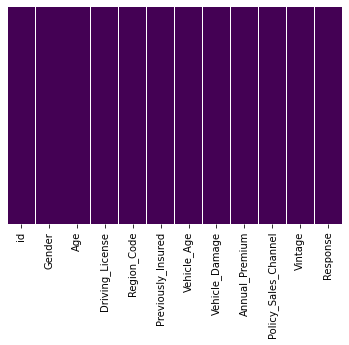

In [ ]:
# check null value in dataset
def check_null():
    missing_data = df_train.isnull()
    x = sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')
    y = df_train.isnull().sum()
    return x, y

check_null()

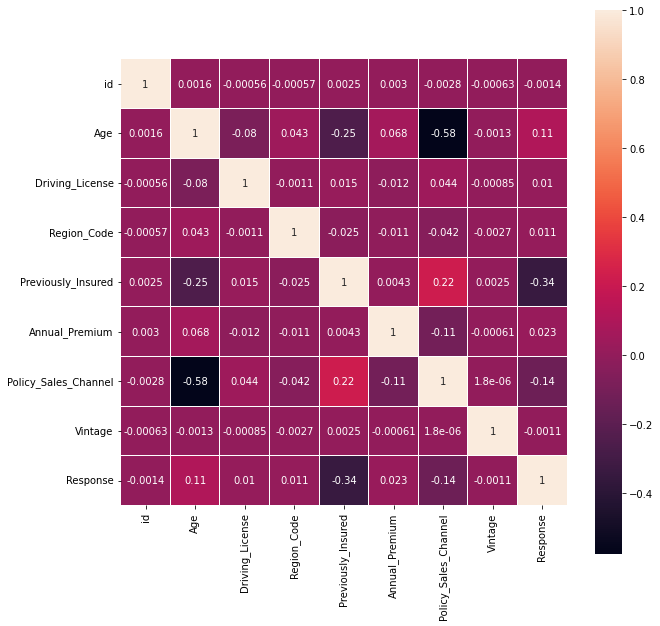

In [ ]:
# correlation matrix of dataset's variables
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_train.corr(), linewidths=0.1, square=True, annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


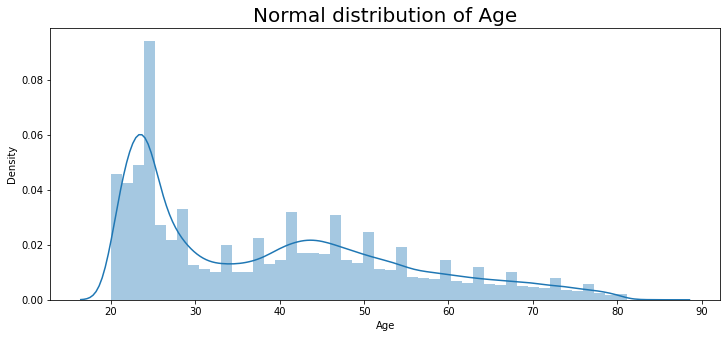

In [ ]:
# normal distribution of dataset's age
# We can see that almost of the age between 20 and 28 is the age which have most people ownning vehicle.
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.distplot(df_train.Age)
ax.set_title('Normal distribution of Age', fontsize=20)

plt.show()

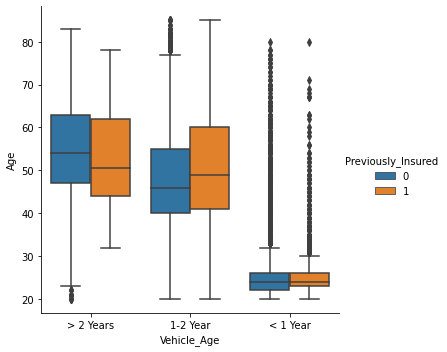

In [ ]:
# check the distribution of numerical 'Age' and 'Vehicle_age'
# In this boxplot chart, we see the newer vehicle that people purchase, the less insurance they buy.
# The main of customer, who buy insurance, own vehicle age are more than 1 year.

sns.catplot(y='Age', x='Vehicle_Age', kind='box', hue='Previously_Insured',data=df_train)

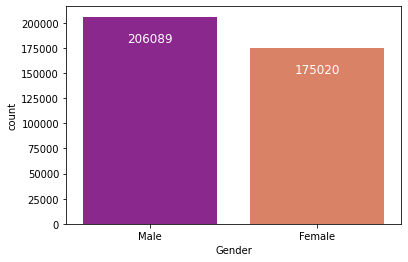

In [ ]:
# Comparsion gender of dataset
ax = sns.countplot(x="Gender", data=df_train, palette="plasma")

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)
plt.show()

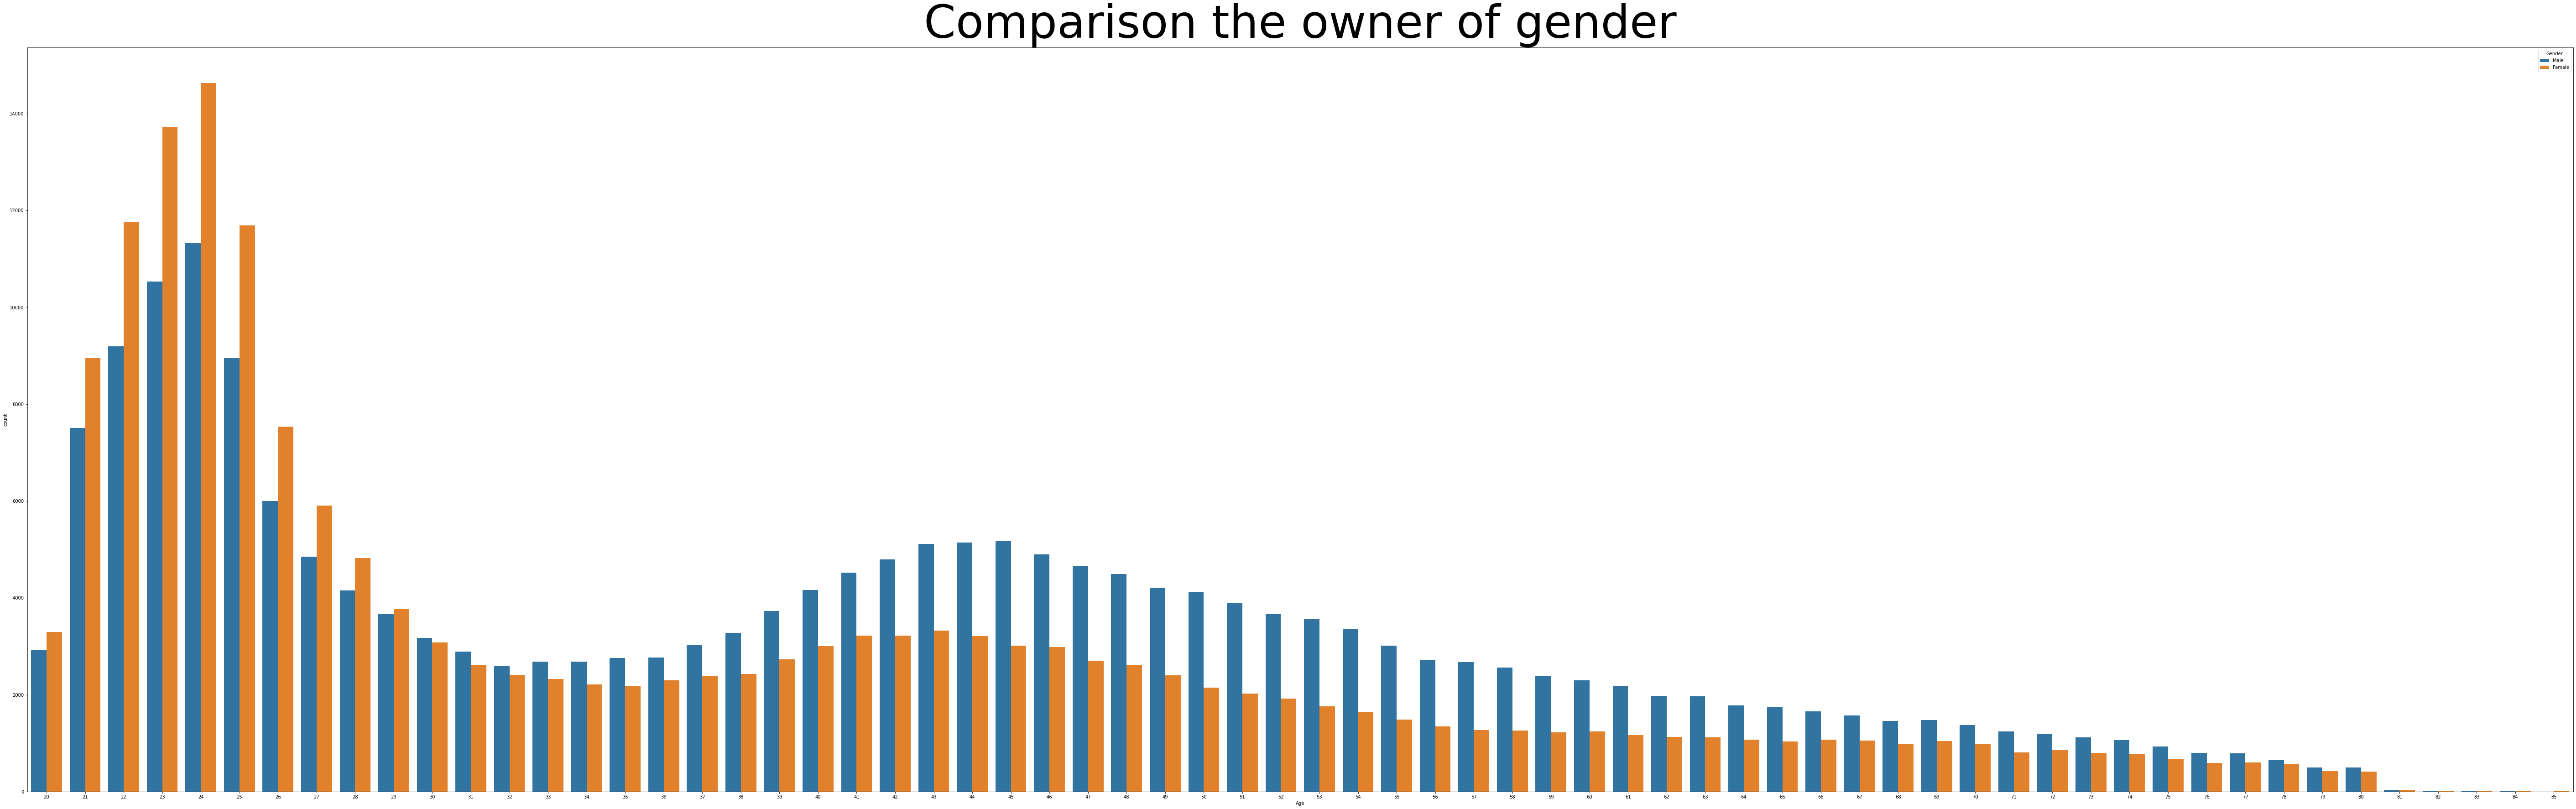

In [ ]:
# The blue chart which is women has the right-skewed distribution, while men are mostly concentrated in their from 20 to 30. 
fig_dims = (100,30)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_title('Comparison the owner of gender', fontsize=100)
sns.countplot(x='Age', hue='Gender', data=df_train)

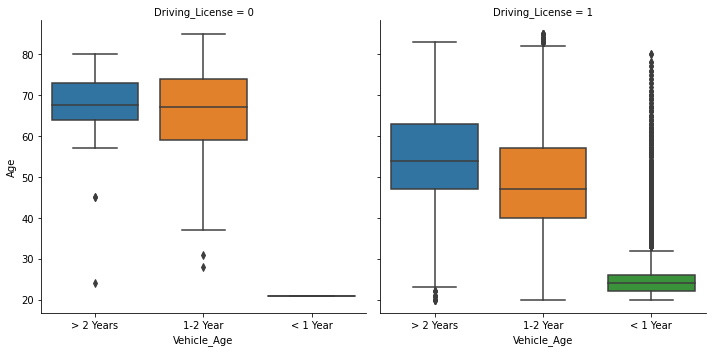

In [ ]:
# We can see that almost younger who own new car have driving license later. This group is the most people who buy new vehicle.
# Suprising, from 20 to 30 is the age that almost people own vehicle. However, there are very little of them have driving license.
sns.catplot(y='Age', x='Vehicle_Age', col='Driving_License', kind="box", data=df_train)

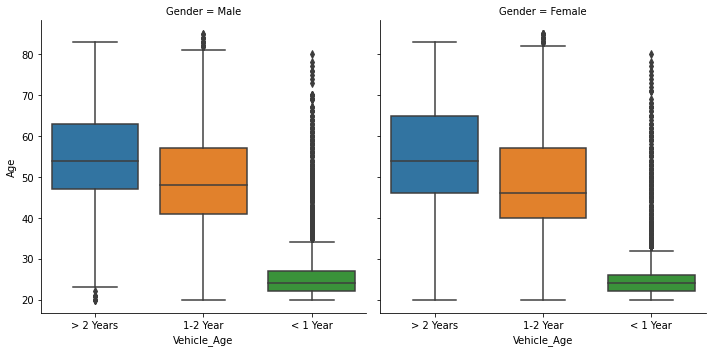

In [ ]:
# In this chart, we can see that female (gender=0) has the same trend with male 
# when they have the normal distribution of owning old or new vehicle.
sns.catplot(y='Age', x='Vehicle_Age', col='Gender', kind="box", data=df_train)

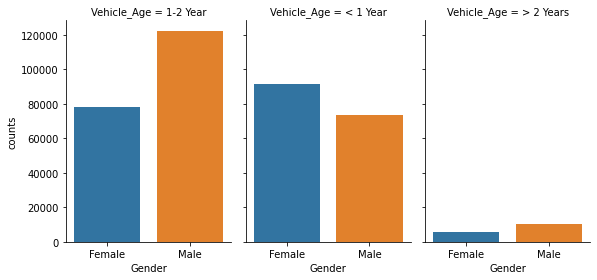

In [ ]:
# We can see that almost of dataset who own vehicle lower 1 year and from 1 to 2 years have most of number.
def gender_vehicle_age():
    i = df_train.groupby(["Gender","Vehicle_Age"])
    j = i["id"].count()
    j = j.to_frame().rename(columns={"id":"counts"}).reset_index()
    ax =sns.catplot(x="Gender",y="counts",col="Vehicle_Age",data=j,kind="bar",height=4, aspect=.7)
    return ax
gender_vehicle_age()

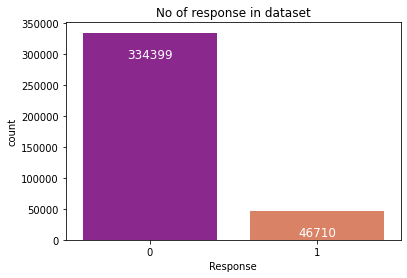

In [ ]:
# count the value of 'Response' column
# There are only 46,710 people who have responsed 'yes' in dataset. So we will train these people based on their information.
ax = sns.countplot(x="Response", data=df_train, palette="plasma")
ax.set_title('No of response in dataset', fontsize=12)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)
plt.show()

(<seaborn.axisgrid.FacetGrid at 0x7f0cc27db190>,
 <seaborn.axisgrid.FacetGrid at 0x7f0cc26e0b10>)

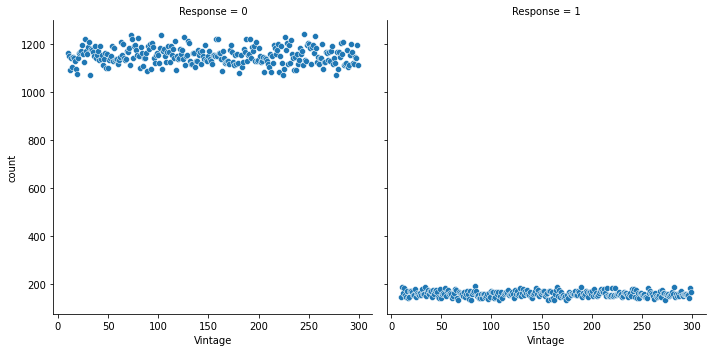

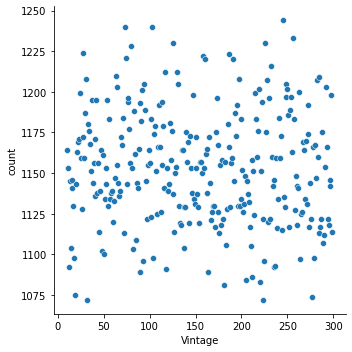

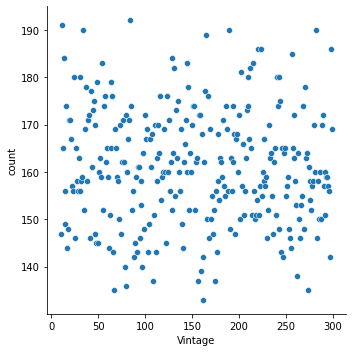

In [ ]:
def response_vintage():
    x = df_train.groupby(["Response","Vintage"])
    x = x.id.count().to_frame().rename(columns={"id":"count"}).reset_index()
    x_0 = x.loc[x["Response"]==0]
    x_1 = x.loc[x["Response"]==1]
  
    ax = sns.relplot(x="Vintage",y="count", col='Response', data=x)
    ay = sns.relplot(x="Vintage",y="count", data=x_0)
    az = sns.relplot(x="Vintage",y="count", data=x_1)
    return ax, ay, az
response_vintage()

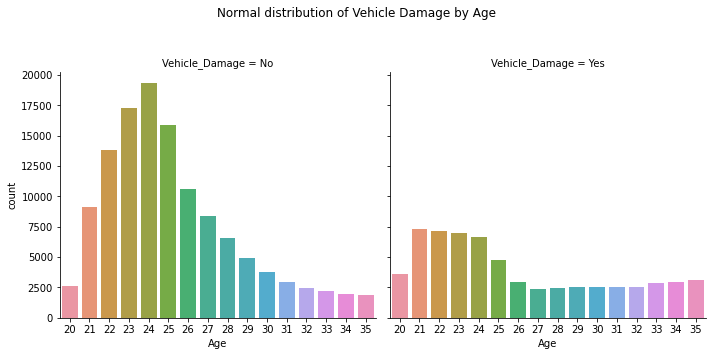

In [ ]:
def group_young_VD():
    x = df_train.groupby(["Age","Vehicle_Damage"])
    x = x["id"].count().to_frame()
    x = x.rename(columns={"id":"count"}).reset_index()
    y = x.loc[x["Age"]<36]
    
    z = sns.catplot(x="Age",y="count",col="Vehicle_Damage",kind="bar",data=y)
    z.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    z.fig.suptitle('Normal distribution of Vehicle Damage by Age')
    
    return z

group_young_VD()

No of Young Group don't have Driving License: 4
No of Young Group have Driving License: 181872


(<seaborn.axisgrid.FacetGrid at 0x7f0cc2470290>, None, None)

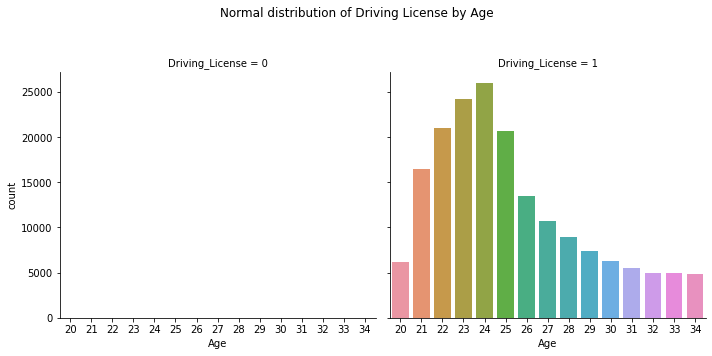

In [ ]:
def group_young_DL():
    x = df_train.groupby(["Age","Driving_License"])["id"].count()
    y = x.reset_index()
    y = y.rename(columns={"id":"count"})
    z = y.loc[y["Age"]<35]
    
    ax = sns.catplot(x="Age",y="count",col="Driving_License",data=z,kind="bar")
    ax.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    ax.fig.suptitle('Normal distribution of Driving License by Age')
    
    x1 = z.loc[z["Driving_License"]==0]["count"].sum()
    y1 = z.loc[z["Driving_License"]==1]["count"].sum()
    ay = print("No of Young Group don't have Driving License:",x1)
    az = print("No of Young Group have Driving License:",y1)
    return ax, ay, az

group_young_DL()

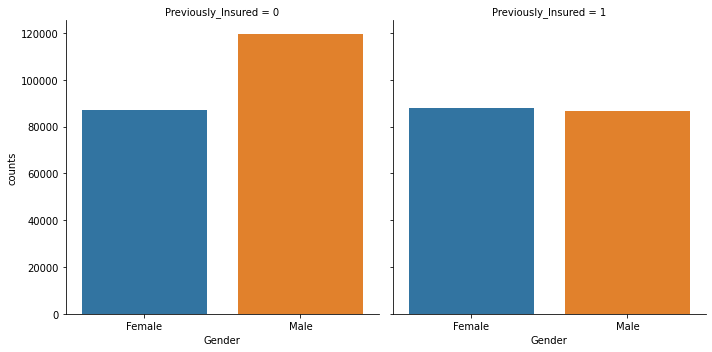

In [ ]:
# there is no diffence of gender in having prviously insured.

def previous_insuranced_gender():
    pre_ins_gen=df_train.groupby(["Gender","Previously_Insured"])["id"].count().to_frame().rename(columns={"id":"counts"}).reset_index()
    
    M_no_insurance = pre_ins_gen.loc[(pre_ins_gen["Gender"]==0)&(pre_ins_gen["Previously_Insured"]==0)]["counts"].sum()
    M_insurance = pre_ins_gen.loc[(pre_ins_gen["Gender"]==0)&(pre_ins_gen["Previously_Insured"]==1)]["counts"].sum()
    
    F_no_insurance = pre_ins_gen.loc[(pre_ins_gen["Gender"]==1)&(pre_ins_gen["Previously_Insured"]==0)]["counts"].sum()
    F_insurance = pre_ins_gen.loc[(pre_ins_gen["Gender"]==1)&(pre_ins_gen["Previously_Insured"]==1)]["counts"].sum()
    
    ax = sns.catplot(x="Gender",y="counts",col="Previously_Insured",kind="bar",data=pre_ins_gen)
    return ax

previous_insuranced_gender()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0cc2b5e950>,
 <seaborn.axisgrid.FacetGrid at 0x7f0cc084fb90>)

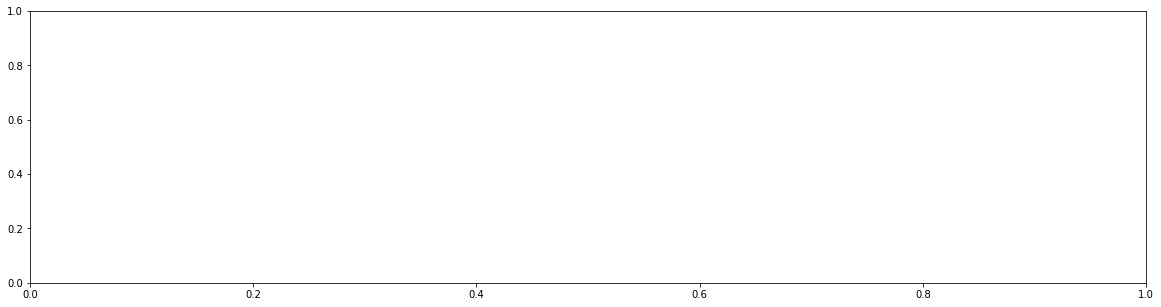

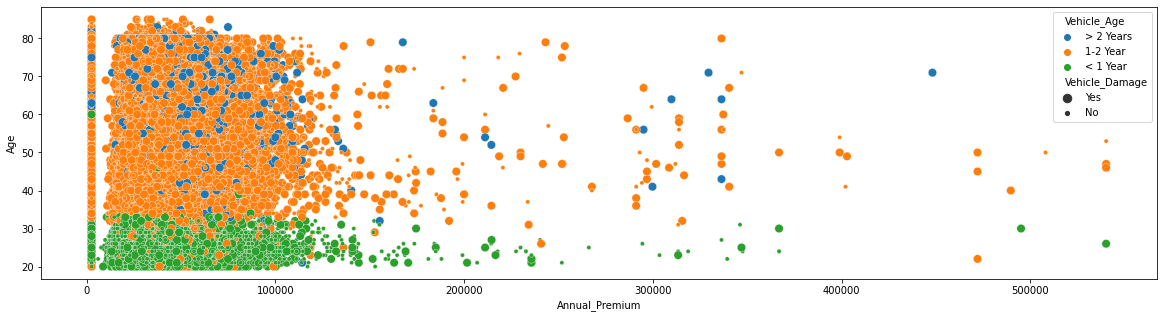

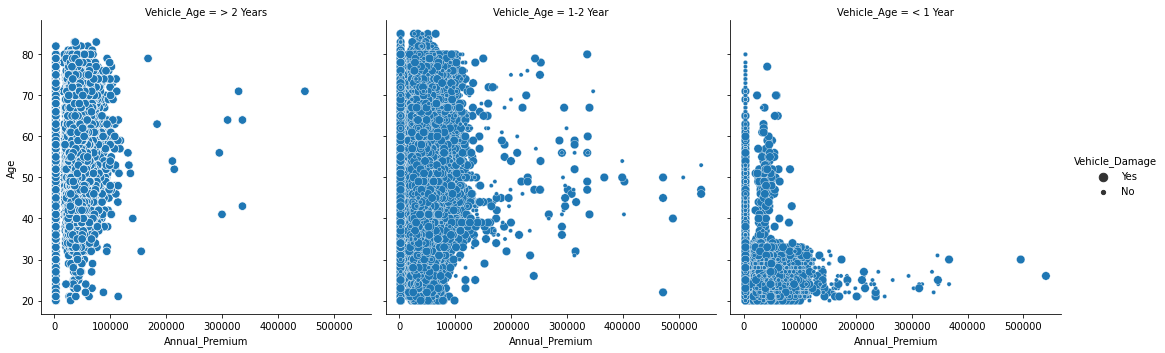

In [ ]:
# Once again, we see that alomost of young people own new vehicle.
# Suprisingly, vehicle age more than 2 years have less damage than newers. 
def scatter_plot():
    fig_dims = (20,5)
    fig, ax= plt.subplots(figsize=fig_dims)
    fig, ay= plt.subplots(figsize=fig_dims)
    ax = sns.scatterplot(df_train["Annual_Premium"],df_train["Age"],hue=df_train["Vehicle_Age"], size=df_train["Vehicle_Damage"])
    ay = sns.relplot(x="Annual_Premium",y="Age",size="Vehicle_Damage",col="Vehicle_Age",data=df_train,kind="scatter")
    return ax, ay
scatter_plot()

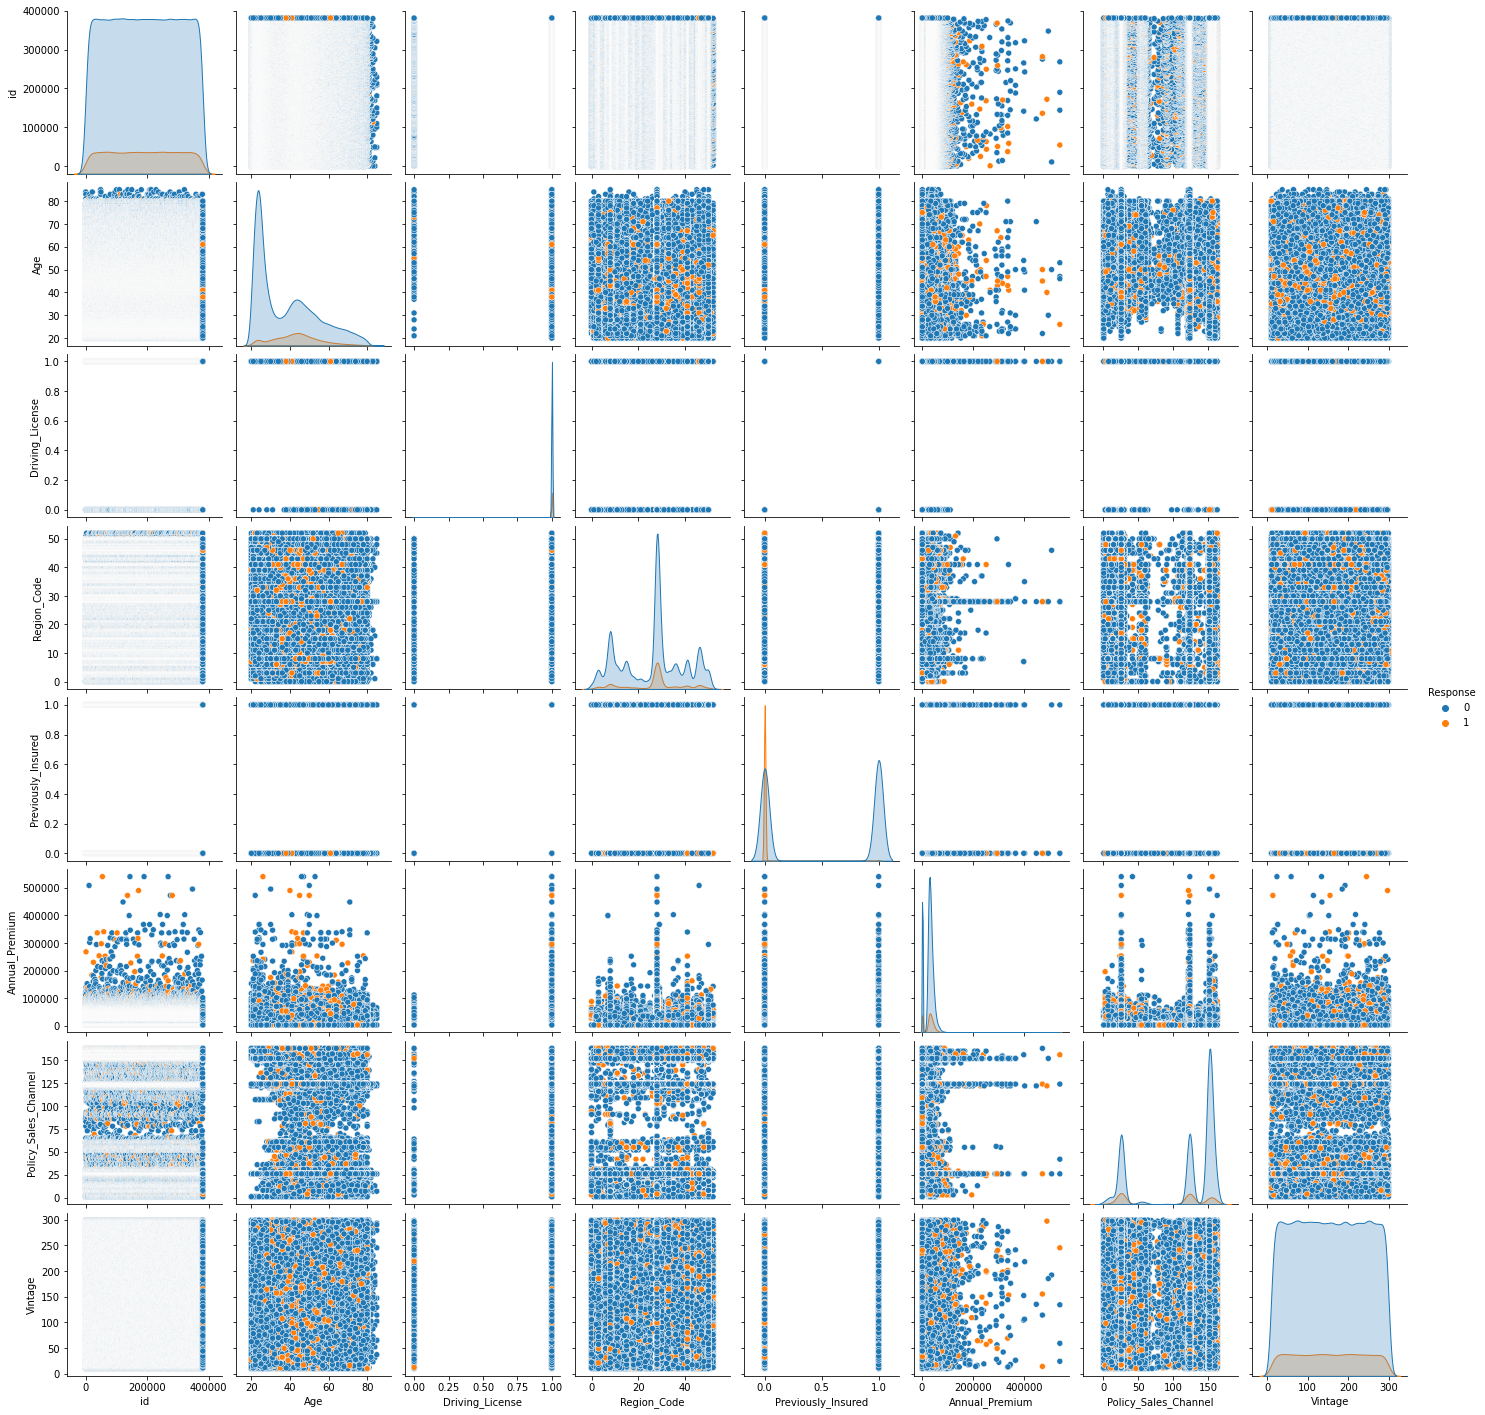

In [ ]:
# Region doesn't show a very strong connection to the Annual Premium
sns.pairplot(df_train, hue='Response')

# 3.Feature Engineering 

In [14]:
df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].map({'Yes': 1, 'No':0})
df_train['Gender'] = df_train['Gender'].map({'Female': 0, 'Male': 1})
df_train['Vehicle_Age'] = df_train["Vehicle_Age"].map({'> 2 Years': 2, '1-2 Year': 1,"< 1 Year":0})

df_train.head(1)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1


In [15]:
df_test['Vehicle_Damage'] = df_test['Vehicle_Damage'].map({'Yes': 1, 'No':0})
df_test['Gender'] = df_test['Gender'].map({'Female': 0, 'Male': 1})
df_test['Vehicle_Age'] = df_test["Vehicle_Age"].map({'> 2 Years': 2, '1-2 Year': 1,"< 1 Year":0})

df_test.head(1)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,25,1,11.0,1,0,0,35786.0,152.0,53


In [16]:
test_ids = df_test['id'].tolist()
train_df = df_train.drop('id', axis=1)

X = train_df.drop('Response', axis=1)
y = train_df['Response']


In [17]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39


In [18]:
#Train & test split with 0.3%

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=4, stratify=y) 

print('X train Shape :',X_train.shape)
print('X test Shape :',y_train.shape)

X train Shape : (266776, 10)
X test Shape : (266776,)


In [19]:
# Saving result of models
result_df = pd.DataFrame(columns=['Model_Name','Accuracy_score_test', 'roc_auc_score_test','f1_score_test', 'precision_score_test', 'recall_score_test'  ])

result_df

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test


In [20]:
#Defining a function to append metrics in dataframe

def model_score_card(model, name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    
    #train datset
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[::, 1]
    
    #test datset
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[::, 1]
    
    global result_df
    
    result_df = result_df.append({'Model_Name' : name,
                                  'Accuracy_score_test':accuracy_score(y_test, y_test_pred),
                                  'f1_score_test' :f1_score(y_test, y_test_pred),
                                  'roc_auc_score_test' : roc_auc_score(y_test, y_test_proba),
                                  'precision_score_test' : precision_score(y_test, y_test_pred),
                                  'recall_score_test' : recall_score(y_test, y_test_pred)}, ignore_index = True)
    
    return result_df

In [21]:
#Defining a function to get evaluation metrics

def model_eval(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    
    #train datset
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[::, 1]

    #test datset
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[::, 1]
    print('\n\nTest dataset :')
    print('Confusion matrix :\n', confusion_matrix(y_test, y_test_pred))
    print('Accuracy :',accuracy_score(y_test, y_test_pred) )
    print('AUC score :', roc_auc_score(y_test, y_test_proba))
    print('F1-score :', f1_score(y_test, y_test_pred))
    print('Precision score :', precision_score(y_test, y_test_pred))
    print('Recall score :', recall_score(y_test, y_test_pred))

# 4.Modeling

## 4.1 Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

### a. Logistic Regression - normal parameters

In [22]:
LR_model = LogisticRegression(solver='liblinear',random_state=4)
model_eval(LR_model)



Test dataset :
Confusion matrix :
 [[100320      0]
 [ 14013      0]]
Accuracy : 0.8774369604576107
AUC score : 0.6002700553262743
F1-score : 0.0
Precision score : 0.0
Recall score : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
model_score_card(LR_model, 'Logistic Regression')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.60027,0.0,0.0,0.0


Logistic Regression Base model :


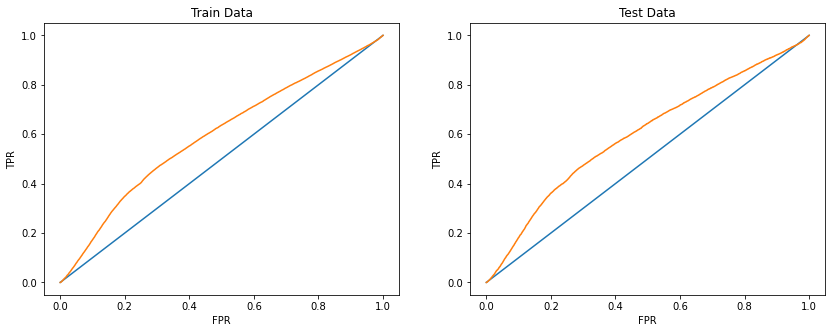

In [24]:
# LR_model = LogisticRegression(solver='liblinear',random_state=4)
LR_model.fit(X_train, y_train)
    
#train datset
y_train_pred = LR_model.predict(X_train)
y_train_proba = LR_model.predict_proba(X_train)[::, 1]
    
#test datset
y_test_pred = LR_model.predict(X_test)
y_test_proba = LR_model.predict_proba(X_test)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_train_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('Logistic Regression Base model :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

### b. Logistic Regression - Hyper-parameters tuning

In [25]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
X_full.shape,y_full.shape

((381109, 10), (381109,))

In [26]:
#estimator used is LogisticRegression
# LR_model = LogisticRegression(solver='liblinear',random_state=4)

#RUN RFECV to find out the best number of features to be selected
rfe_n = RFECV(estimator=LR_model, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
rfe_n.fit(X_full, y_full)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFECV(cv=3,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=4,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=2)

In [27]:
#Selected features
selected = list(X_train.columns[rfe_n.support_]) # replace with X_full
print('\nSelected features :',selected)


Selected features : ['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']


In [28]:
#selecting only features from RFE in both train & test dataset

X_train_sel = X_train[selected]
X_test_sel = X_test[selected]

model_eval(LR_model, X_train_sel, X_test_sel, y_train, y_test)



Test dataset :
Confusion matrix :
 [[100273     47]
 [ 13982     31]]
Accuracy : 0.8772970183586541
AUC score : 0.8308811745325115
F1-score : 0.004399971613086367
Precision score : 0.3974358974358974
Recall score : 0.002212231499322058


In [29]:
smote = SMOTE(sampling_strategy='minority')

#SMOTE analysis on train dataset
X_train_sm, y_train_sm = smote.fit_resample(X_train_sel, y_train)

print('Shape of X train', X_train_sm.shape)

#after smote analysis, target variable is equally distributed

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of X train (468158, 7)


In [30]:
#Model evaluation
model_eval(LR_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[59406 40914]
 [  344 13669]]
Accuracy : 0.6391418050781489
AUC score : 0.8312572166128263
F1-score : 0.3985363578051198
Precision score : 0.25042595679973617
Recall score : 0.9754513665881681


In [31]:
## Appending the evaluation metrics in a DataFrame for further reference
##This is the final base model
model_score_card(LR_model, 'Logistic Regression with Hyper-parameters tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451


Logistic Regression Final-Base_model :


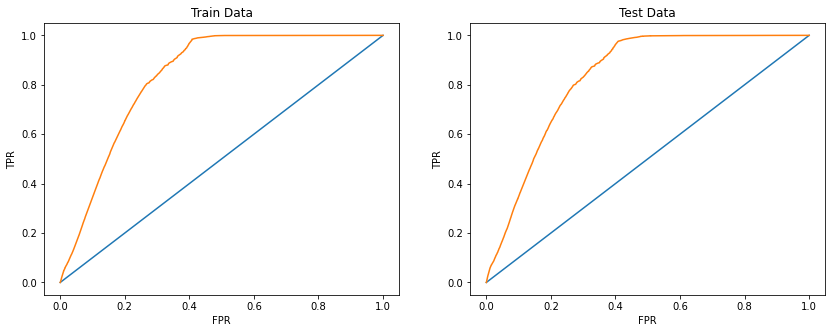

In [32]:
LR_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = LR_model.predict(X_train_sm)
y_train_sm_proba = LR_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = LR_model.predict(X_test_sel)
y_test_proba = LR_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('Logistic Regression Final-Base_model :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 4.2 Random Forest

Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree spits out a class prediction and the class with the most votes. It can be used for both Regression and Classification model. 

### a. Random forest Classifier

In [33]:
#Build RFC model on Dataset which are : RFE selected features, smote analysed

RF_model = RandomForestClassifier(random_state=4)

#model evaluation
model_eval(RF_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[71702 28618]
 [ 2272 11741]]
Accuracy : 0.7298242852019977
AUC score : 0.8370536430713518
F1-score : 0.431876701243287
Precision score : 0.29091404643326146
Recall score : 0.8378648397916221


### b. Random forest Classifier with Hyper-parameter tuning

In [34]:
# GridSearchCV & RandomizedSearchCV results were almost similar
# Considering RandomizedSearchCV for Hyper-parameter tuning
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from scipy.stats import randint as sp_randint
params = {'n_estimators': sp_randint(50,200),
          'max_features': sp_randint(1,15),
          'min_samples_leaf' : sp_randint(1,25),
          'max_depth' : sp_randint(1,10),
          'criterion' : ['gini', 'entropy']}

rsearch = RandomizedSearchCV(RF_model, param_distributions=params, cv=3, n_iter=10,verbose=2, 
                             scoring='roc_auc', random_state=4, n_jobs=-1)
rsearch.fit(X_train_sm, y_train_sm) # replace with full

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [35]:
#Best parameters
print(rsearch.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 10, 'n_estimators': 108}


In [36]:
RF_model = RandomForestClassifier(**rsearch.best_params_, random_state=4)

model_eval(RF_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[66315 34005]
 [  987 13026]]
Accuracy : 0.6939466295820105
AUC score : 0.851336501401467
F1-score : 0.42677413013563986
Precision score : 0.2769662562990368
Recall score : 0.9295654035538429


In [37]:
model_score_card(RF_model, 'RandomForestClassifier HyperParameter-tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565


RandomForestClassifier HyperParameter-tuning :


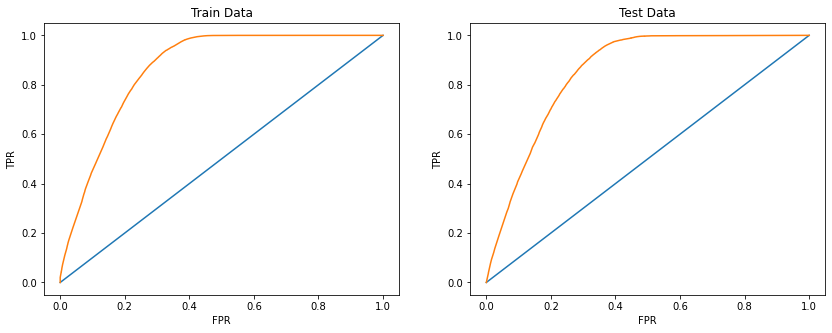

In [38]:
RF_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = RF_model.predict(X_train_sm)
y_train_sm_proba = RF_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = RF_model.predict(X_test_sel)
y_test_proba = RF_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('RandomForestClassifier HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 4.3 Decision Tree Classifier

Decision Tree Model is a type of classification where the function is only approximated locally and all computation is deferred until function evaluation.

### a. Decision Tree Classifier

In [39]:
#from sklearn.tree import DecisionTreeClassifier

#Build DTC model on Dataset which are : RFE selected features, smote analysed
DT_model = DecisionTreeClassifier()
model_eval(DT_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[71741 28579]
 [ 2317 11696]]
Accuracy : 0.729771806914889
AUC score : 0.8250041951674858
F1-score : 0.43088712054229295
Precision score : 0.2904034761018001
Recall score : 0.8346535360022836


### b. Decision Tree Classifier with Hyper-parameter tuning

In [40]:
# GridSearchCV & RandomizedSearchCV results were almost similar
# We are considering RandomizedSearchCV for Hyper-parameter tuning

DT_model = DecisionTreeClassifier(random_state=4)

params = {'max_depth' : sp_randint(2,10),
          'min_samples_leaf' : sp_randint(1,12),
          'criterion' : ['gini', 'entropy']}

rsearch = RandomizedSearchCV(DT_model, param_distributions=params, n_iter=100, n_jobs=-1, 
                             cv=3, scoring='roc_auc', random_state=4)

# RandomizedSearchCV on overall transformed datasets
rsearch.fit(X_train_sm, y_train_sm) #replace with full

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=4,
             

In [41]:
#Best parameters
print(rsearch.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3}


In [42]:
DT_model = DecisionTreeClassifier(**rsearch.best_params_, random_state=4)

model_eval(DT_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[67237 33083]
 [ 1143 12870]]
Accuracy : 0.7006463575695556
AUC score : 0.8484146456736288
F1-score : 0.4292432378347731
Precision score : 0.28006876591299806
Recall score : 0.9184328837508028


In [43]:
model_score_card(DT_model, 'DecisionTreeClassifier HyperParameter-tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565
3,DecisionTreeClassifier HyperParameter-tuning,0.700646,0.848415,0.429243,0.280069,0.918433


DecisionTreeClassifier HyperParameter-tuning :


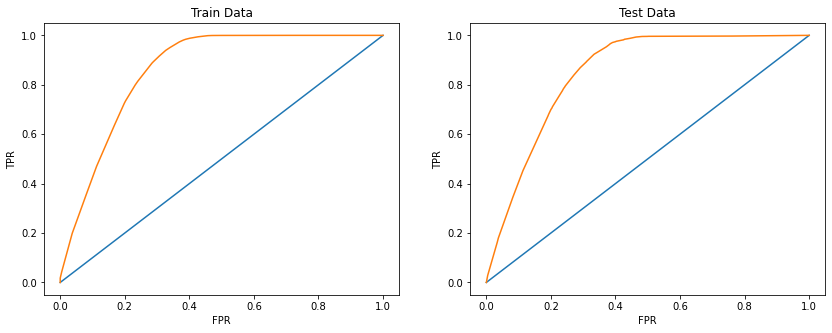

In [44]:
DT_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = DT_model.predict(X_train_sm)
y_train_sm_proba = DT_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = DT_model.predict(X_test_sel)
y_test_proba = DT_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('DecisionTreeClassifier HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 4.4 LGBMClassifier

The LightGBM Classifier has become a de facto algorithm for machine learning competitions when working with tabular data for regression and classification predictive modeling tasks. As such, it owns a share of the blame for the increased popularity and wider adoption of gradient boosting methods in general.

### a. LGBMClassifier

In [45]:
# import lightgbm as lgb

#Build RFC model on Dataset which are : RFE selected features, smote analysed
LGBM_model = lgb.LGBMClassifier()

#model evaluation
model_eval(LGBM_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[69101 31219]
 [ 1444 12569]]
Accuracy : 0.7143169513613742
AUC score : 0.8522017053457196
F1-score : 0.4349059704849397
Precision score : 0.28704211199415364
Recall score : 0.89695282951545


### b. LGBMClassifier with Hyper-parameter tuning

In [46]:
# from scipy.stats import uniform as sp_uniform

params = {'n_estimators':sp_randint(50,250),
          'max_depth' : sp_randint(1,50),
          'learning_rate' : sp_uniform(0,0.5)}

rsearch = RandomizedSearchCV(LGBM_model, param_distributions=params, scoring='roc_auc', cv=3, n_iter=10,
                             n_jobs=-1, random_state=4)
rsearch.fit(X_train_sm, y_train_sm) # replace with full

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fce6c405ad

In [47]:
#Best parameters
print(rsearch.best_params_)

{'learning_rate': 0.48351491950683834, 'max_depth': 6, 'n_estimators': 179}


In [48]:
LGBM_model = lgb.LGBMClassifier(**rsearch.best_params_, random_state=4)

model_eval(LGBM_model,  X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[70889 29431]
 [ 1947 12066]]
Accuracy : 0.7255560511838227
AUC score : 0.8485705031702734
F1-score : 0.43473248063412
Precision score : 0.2907680073258308
Recall score : 0.8610575893812888


In [49]:
# LGBMClassifier model results before and after hyper-parameter tuning is same, Model is slightly over-fit

## Appending the evaluation metrics in a DataFrame for further reference
model_score_card(LGBM_model, 'LGBMClassifier with Hyper-parameters tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565
3,DecisionTreeClassifier HyperParameter-tuning,0.700646,0.848415,0.429243,0.280069,0.918433
4,LGBMClassifier with Hyper-parameters tuning,0.725556,0.848571,0.434732,0.290768,0.861058


LGBMClassifier HyperParameter-tuning :


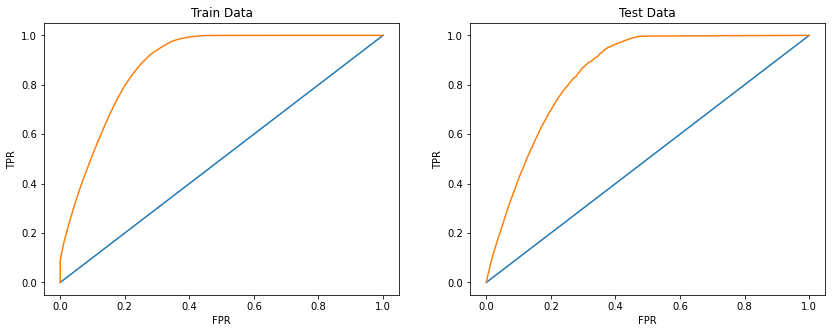

In [50]:
LGBM_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = LGBM_model.predict(X_train_sm)
y_train_sm_proba = LGBM_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = LGBM_model.predict(X_test_sel)
y_test_proba = LGBM_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('LGBMClassifier HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 4.5 Naive Bayes

Gaussian Naive Bayes is a simple but powerful algorithm for predictive modeling under supervised learning algorithms. Naive Bayes has higher accuracy and speed when we have large data points

### a. GaussianNB SMOTE analysis

In [51]:
#Model built on transformed data
NB_model = GaussianNB()

model_eval(NB_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[59398 40922]
 [  336 13677]]
Accuracy : 0.6391418050781489
AUC score : 0.8228579496158216
F1-score : 0.39867661633533497
Precision score : 0.2504990933899888
Recall score : 0.9760222650396061


 GaussianNB :


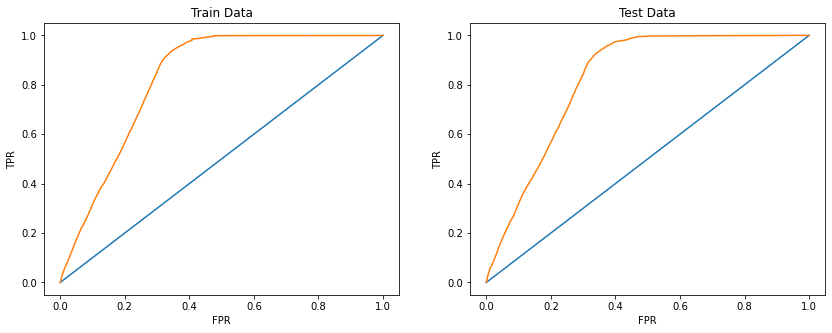

In [52]:
NB_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = NB_model.predict(X_train_sm)
y_train_sm_proba = NB_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = NB_model.predict(X_test_sel)
y_test_proba = NB_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' GaussianNB :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

### b. GaussianNB Hyper-parameter Tuning

In [53]:
#default var_smoothing is 1e-09
#We can try a range between 1e-0.15 to 1e-0.5

params_NB = {'var_smoothing': np.logspace(-5, -15, num=200)}
research = GridSearchCV(estimator=NB_model,
                        param_grid=params_NB,
                        cv=3,   # use any cross validation technique
                        verbose=1,
                        scoring='accuracy') 
research.fit(X_train_sm, y_train_sm) # replace with full

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': array([1.00000000e-05, 8.90735464e-06, 7.93409667e-06, 7.06718127e-06,
       6.29498899e-06, 5.60716994e-06, 4.99450512e-06, 4.44878283e-06,
       3.96268864e-06, 3.52970730e-06, 3.14403547e-06, 2.80050389e-06,
       2.49450814e-06, 2.2...
       9.01101825e-15, 8.02643352e-15, 7.14942899e-15, 6.36824994e-15,
       5.67242607e-15, 5.05263107e-15, 4.50055768e-15, 4.00880633e-15,
       3.57078596e-15, 3.18062569e-15, 2.83309610e-15, 2.52353917e-15,
       2.24780583e-15, 2.00220037e-15, 1.78343088e-15, 1.58856513e-15,
       1.41499130e-15, 1.26038293e-15, 1.12266777e-15, 1.00000000e-15])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [54]:
#Best parameters
print(research.best_params_)

{'var_smoothing': 3.52970730273065e-06}


In [55]:
NB_model = GaussianNB(**research.best_params_)

#As we got better result on GaussianNB for data without SMOTE analysis, we will use the same dataset
model_eval(NB_model,  X_train_sm, X_test_sel, y_train_sm, y_test)




Test dataset :
Confusion matrix :
 [[59397 40923]
 [  336 13677]]
Accuracy : 0.6391330586969641
AUC score : 0.8231917515701699
F1-score : 0.3986708058239692
Precision score : 0.25049450549450547
Recall score : 0.9760222650396061


 GaussianNB HyperParameter-tuning :


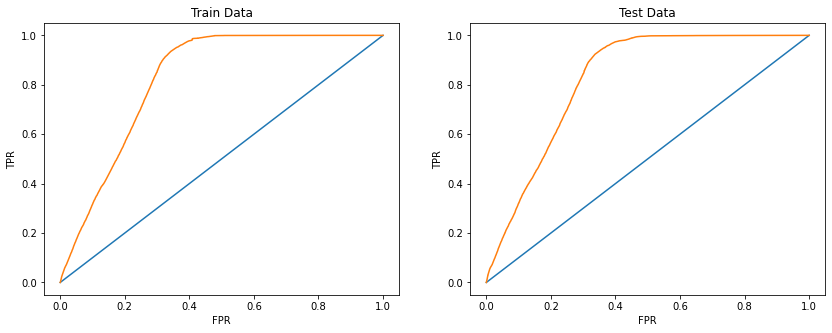

In [56]:
NB_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = NB_model.predict(X_train_sm)
y_train_sm_proba = NB_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = NB_model.predict(X_test_sel)
y_test_proba = NB_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' GaussianNB HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

In [57]:
# GaussianNB model results before and after hyper-parameter tuning is same, Model is better fit to rest of the models
## Appending the evaluation metrics in a DataFrame for further reference
## We can consider GaussianNB before hyper-parameter tuning

model_score_card(NB_model, 'GaussianNB with Hyper-parameters tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565
3,DecisionTreeClassifier HyperParameter-tuning,0.700646,0.848415,0.429243,0.280069,0.918433
4,LGBMClassifier with Hyper-parameters tuning,0.725556,0.848571,0.434732,0.290768,0.861058
5,GaussianNB with Hyper-parameters tuning,0.639133,0.823192,0.398671,0.250495,0.976022


## 4.6 Catboost

Catboost Model is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi.

### a. Catboost

In [58]:
%%time

CB_model = CatBoostClassifier(thread_count=2,
                              loss_function='Logloss',
                              od_type = 'Iter',
                              verbose= False)
model_eval(CB_model, X_train_sm, X_test_sel, y_train_sm, y_test)



Test dataset :
Confusion matrix :
 [[71028 29292]
 [ 2041 11972]]
Accuracy : 0.725949638337138
AUC score : 0.8485533259245146
F1-score : 0.4331638837129366
Precision score : 0.2901318340442032
Recall score : 0.8543495325768928
CPU times: user 4min 52s, sys: 3.58 s, total: 4min 56s
Wall time: 2min 34s


 Catboost :


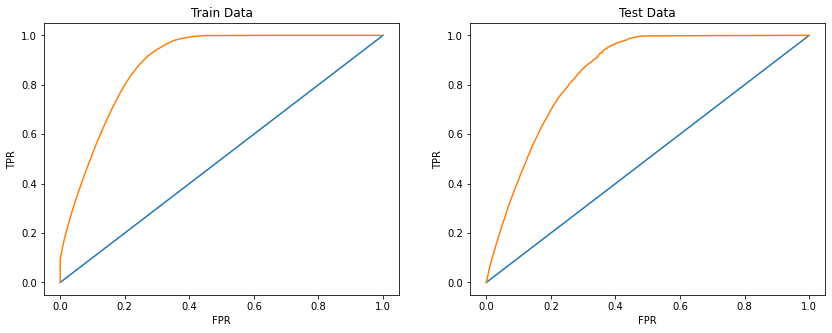

In [59]:
CB_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = CB_model.predict(X_train_sm)
y_train_sm_proba = CB_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = CB_model.predict(X_test_sel)
y_test_proba = CB_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' Catboost :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

### b. Catboost with Hyper-parameters tuning

In [60]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:', best_params)
    return best_params

In [61]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [62]:
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False
                        )

In [63]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# Defining your search space
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [64]:
# Setting up BayesSearchCV
opt = BayesSearchCV(CB_model,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [65]:
best_params = report_perf(opt, X_train_sm, y_train_sm,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                          DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 239.1027
Function value obtained: -0.8778
Current minimum: -0.8778
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 535.2400
Function value obtained: -0.8688
Current minimum: -0.8778
Iteration No: 3 started. Searching for the next optimal point.
CatBoost took 832.69 seconds,  candidates checked: 2, best CV score: 0.878 ± 0.001
Best parameters: OrderedDict([('bagging_temperature', 0.41010395885331385), ('border_count', 186), ('depth', 8), ('iterations', 323), ('l2_leaf_reg', 21), ('learning_rate', 0.0673344419215237), ('random_strength', 3.230824361824754e-06), ('scale_pos_weight', 0.7421091918485163)])


In [66]:
CB_model = CatBoostClassifier(**best_params,task_type = "GPU",od_type='Iter',one_hot_max_size=10)


In [67]:
CB_model.fit(X_train_sm, y_train_sm)

0:	learn: 0.6207686	total: 33.7ms	remaining: 10.8s
1:	learn: 0.5685092	total: 63.8ms	remaining: 10.2s
2:	learn: 0.5317854	total: 90.9ms	remaining: 9.7s
3:	learn: 0.5051935	total: 121ms	remaining: 9.63s
4:	learn: 0.4858971	total: 153ms	remaining: 9.74s
5:	learn: 0.4703856	total: 183ms	remaining: 9.68s
6:	learn: 0.4599590	total: 219ms	remaining: 9.88s
7:	learn: 0.4521606	total: 251ms	remaining: 9.89s
8:	learn: 0.4460949	total: 281ms	remaining: 9.79s
9:	learn: 0.4412316	total: 310ms	remaining: 9.71s
10:	learn: 0.4368375	total: 336ms	remaining: 9.52s
11:	learn: 0.4333652	total: 359ms	remaining: 9.29s
12:	learn: 0.4306361	total: 392ms	remaining: 9.34s
13:	learn: 0.4283897	total: 415ms	remaining: 9.15s
14:	learn: 0.4256084	total: 440ms	remaining: 9.03s
15:	learn: 0.4239825	total: 477ms	remaining: 9.15s
16:	learn: 0.4224538	total: 502ms	remaining: 9.04s
17:	learn: 0.4206875	total: 526ms	remaining: 8.91s
18:	learn: 0.4196019	total: 549ms	remaining: 8.79s
19:	learn: 0.4183877	total: 573ms	remai

In [68]:
#CB_model.fit(X_train_sm, y_train_sm)
y_test_predict = CB_model.predict(X_test_sel)
model_score = CB_model.score(X_test_sel, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.7465473660273062
[[73723 26597]
 [ 2381 11632]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.84    100320
           1       0.30      0.83      0.45     14013

    accuracy                           0.75    114333
   macro avg       0.64      0.78      0.64    114333
weighted avg       0.89      0.75      0.79    114333



In [69]:
model_eval(CB_model, X_train_sm, X_test_sel, y_train_sm, y_test)

0:	learn: 0.6207686	total: 23.2ms	remaining: 7.48s
1:	learn: 0.5685092	total: 45.9ms	remaining: 7.36s
2:	learn: 0.5317854	total: 67.4ms	remaining: 7.19s
3:	learn: 0.5051934	total: 89.9ms	remaining: 7.17s
4:	learn: 0.4858971	total: 117ms	remaining: 7.47s
5:	learn: 0.4703856	total: 140ms	remaining: 7.42s
6:	learn: 0.4599590	total: 163ms	remaining: 7.35s
7:	learn: 0.4521605	total: 185ms	remaining: 7.27s
8:	learn: 0.4460949	total: 208ms	remaining: 7.25s
9:	learn: 0.4412315	total: 234ms	remaining: 7.33s
10:	learn: 0.4368375	total: 257ms	remaining: 7.28s
11:	learn: 0.4333652	total: 277ms	remaining: 7.18s
12:	learn: 0.4306361	total: 313ms	remaining: 7.46s
13:	learn: 0.4283897	total: 334ms	remaining: 7.38s
14:	learn: 0.4256084	total: 357ms	remaining: 7.33s
15:	learn: 0.4239825	total: 380ms	remaining: 7.29s
16:	learn: 0.4224538	total: 408ms	remaining: 7.34s
17:	learn: 0.4206875	total: 431ms	remaining: 7.29s
18:	learn: 0.4196019	total: 456ms	remaining: 7.3s
19:	learn: 0.4183877	total: 479ms	rema

In [70]:
model_score_card(CB_model, 'Catboost with Hyper-parameters tuning', X_train_sm, X_test_sel, y_train_sm, y_test)

0:	learn: 0.6207686	total: 32.9ms	remaining: 10.6s
1:	learn: 0.5685092	total: 62.8ms	remaining: 10.1s
2:	learn: 0.5317853	total: 102ms	remaining: 10.9s
3:	learn: 0.5051935	total: 131ms	remaining: 10.5s
4:	learn: 0.4858971	total: 161ms	remaining: 10.2s
5:	learn: 0.4703856	total: 191ms	remaining: 10.1s
6:	learn: 0.4599590	total: 223ms	remaining: 10s
7:	learn: 0.4521605	total: 252ms	remaining: 9.92s
8:	learn: 0.4460949	total: 280ms	remaining: 9.77s
9:	learn: 0.4412315	total: 312ms	remaining: 9.77s
10:	learn: 0.4368375	total: 342ms	remaining: 9.7s
11:	learn: 0.4333653	total: 367ms	remaining: 9.5s
12:	learn: 0.4306361	total: 395ms	remaining: 9.41s
13:	learn: 0.4283897	total: 417ms	remaining: 9.21s
14:	learn: 0.4256084	total: 442ms	remaining: 9.08s
15:	learn: 0.4239825	total: 470ms	remaining: 9.02s
16:	learn: 0.4224538	total: 501ms	remaining: 9.01s
17:	learn: 0.4206875	total: 529ms	remaining: 8.97s
18:	learn: 0.4196019	total: 558ms	remaining: 8.93s
19:	learn: 0.4183876	total: 581ms	remaining

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565
3,DecisionTreeClassifier HyperParameter-tuning,0.700646,0.848415,0.429243,0.280069,0.918433
4,LGBMClassifier with Hyper-parameters tuning,0.725556,0.848571,0.434732,0.290768,0.861058
5,GaussianNB with Hyper-parameters tuning,0.639133,0.823192,0.398671,0.250495,0.976022
6,Catboost with Hyper-parameters tuning,0.746547,0.851892,0.445312,0.304272,0.830086


0:	learn: 0.6207686	total: 23.4ms	remaining: 7.53s
1:	learn: 0.5685093	total: 46.2ms	remaining: 7.42s
2:	learn: 0.5317853	total: 67.3ms	remaining: 7.18s
3:	learn: 0.5051935	total: 89.7ms	remaining: 7.15s
4:	learn: 0.4858971	total: 112ms	remaining: 7.12s
5:	learn: 0.4703855	total: 135ms	remaining: 7.13s
6:	learn: 0.4599590	total: 159ms	remaining: 7.19s
7:	learn: 0.4521605	total: 183ms	remaining: 7.2s
8:	learn: 0.4460948	total: 206ms	remaining: 7.2s
9:	learn: 0.4412316	total: 233ms	remaining: 7.29s
10:	learn: 0.4368375	total: 256ms	remaining: 7.25s
11:	learn: 0.4333652	total: 277ms	remaining: 7.17s
12:	learn: 0.4306361	total: 300ms	remaining: 7.15s
13:	learn: 0.4283897	total: 321ms	remaining: 7.08s
14:	learn: 0.4256084	total: 344ms	remaining: 7.05s
15:	learn: 0.4239825	total: 366ms	remaining: 7.02s
16:	learn: 0.4224538	total: 388ms	remaining: 6.99s
17:	learn: 0.4206875	total: 416ms	remaining: 7.05s
18:	learn: 0.4196019	total: 454ms	remaining: 7.26s
19:	learn: 0.4183877	total: 476ms	remai

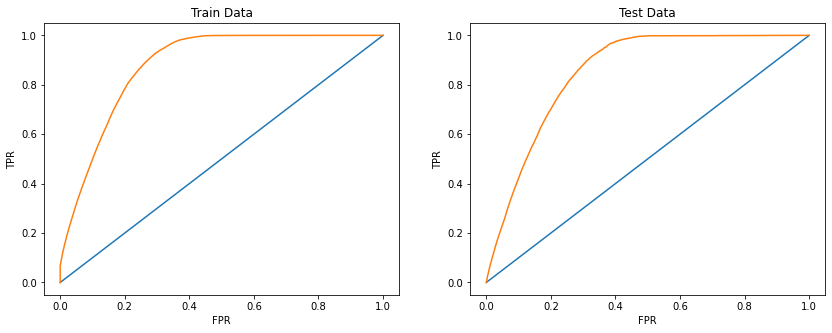

In [71]:
CB_model.fit(X_train_sm, y_train_sm)
    
#train datset
y_train_sm_pred = CB_model.predict(X_train_sm)
y_train_sm_proba = CB_model.predict_proba(X_train_sm)[::, 1]
    
#test datset
y_test_pred = CB_model.predict(X_test_sel)
y_test_proba = CB_model.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' Catboost HyperParameter-tuning  :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

# 5.Export output

## 5.1 Choosing model to apply

In [72]:
result_df

,Model_Name,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877437,0.600270,0.000000,0.000000,0.000000
1,Logistic Regression with Hyper-parameters tuning,0.639142,0.831257,0.398536,0.250426,0.975451
2,RandomForestClassifier HyperParameter-tuning,0.693947,0.851337,0.426774,0.276966,0.929565
3,DecisionTreeClassifier HyperParameter-tuning,0.700646,0.848415,0.429243,0.280069,0.918433
4,LGBMClassifier with Hyper-parameters tuning,0.725556,0.848571,0.434732,0.290768,0.861058
5,GaussianNB with Hyper-parameters tuning,0.639133,0.823192,0.398671,0.250495,0.976022
6,Catboost with Hyper-parameters tuning,0.746547,0.851892,0.445312,0.304272,0.830086


In [74]:
result_df.to_csv('./result.csv')

## 5.2 Save model

In [75]:
import pickle
saved_model = pickle.dumps(CB_model)
for_test_set = pickle.loads(saved_model)
for_test_set.predict(X_test_sel) #X_test_sel

array([0, 0, 0, ..., 1, 0, 0])

In [76]:
df_test_sel = df_test[selected]
df_test_sel.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
0,1,25,1,1,0,0,152.0
1,1,40,1,0,1,1,7.0
2,1,47,1,0,1,1,124.0
3,1,24,1,1,0,1,152.0
4,1,27,1,1,0,0,152.0


In [77]:
X_test_sel.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
3168,1,45,1,1,1,0,26.0
273967,0,50,1,0,1,1,39.0
354601,1,22,1,0,0,1,152.0
117213,0,27,1,1,0,0,26.0
329019,1,80,1,1,1,0,26.0


In [78]:
apply_test = df_test_sel
y_predtest = for_test_set.predict(apply_test)
y_predprobtest = for_test_set.predict_proba(apply_test)
y_predtest

array([0, 1, 1, ..., 0, 0, 0])

In [79]:
submission = pd.DataFrame({'id':df_test['id']
                           ,'Response':y_predtest})

#Visualize the first 5 rows
print("The first 5 rows: ", submission.head(5))
print("The last 5 rows: ", submission.tail(5))

The first 5 rows:         id  Response
0  381110         0
1  381111         1
2  381112         1
3  381113         0
4  381114         0
The last 5 rows:              id  Response
127032  508142         0
127033  508143         1
127034  508144         0
127035  508145         0
127036  508146         0


In [80]:
submission.to_csv('./submission.csv')

## 5.3 Export submission

In [81]:
filename = 'submission.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission.csv


In [82]:
df_sub = pd.read_csv("submission.csv")
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   id        127037 non-null  int64
 1   Response  127037 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


In [83]:
df_sub["Response"].value_counts()

0    84731
1    42306
Name: Response, dtype: int64

In [84]:
df_train["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64